In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import random
%matplotlib inline
import cv2
import os
from subprocess import call

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [76]:
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
def get_measure_note(thickness = 3, height = 45, width = 10):
    measure_note = np.zeros([height,width])
    length = random.randint(height-3,height)
    measure_note[0:length, int(width/2):int(width/2)+thickness] = 255
    rows,cols = measure_note.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-5,5),random.random()*0.12 + 0.95)
    measure_note = cv2.warpAffine(measure_note,M,(cols,rows))
    measure_note = cv2.GaussianBlur(measure_note,(3,3),0)
    return measure_note

In [5]:
def get_rest_bar(thickness = 3, height = 45, width = 10):
    rest_bar = np.zeros([height,width])
    length = random.randint(43,45)
    rest_bar[int(height/2)-1:int(height/2)+thickness-1, 0:10 - random.randint(0,2)] = 255
    rows,cols = rest_bar.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,10),random.random()*0.12 + 0.95)
    rest_bar = cv2.warpAffine(rest_bar,M,(cols,rows))
    rest_bar = cv2.GaussianBlur(rest_bar,(3,3),0)
    return rest_bar

In [6]:
def get_note(last_digit = -1, can_zero=True):
    canvass = np.zeros([45,28])
    index = random.randint(0,x_train.shape[0]-1)
    while y_train[index] > 7 or y_train[index] == last_digit or (not can_zero and y_train[index] == 0):
        index = random.randint(0,x_train.shape[0]-1)
    canvass[4:32,:] = x_train[index]
    label = y_train[index]
    level_vote = random.randint(0,2)
    if level_vote == 0 or label == 0:
        return canvass, label
    
    if level_vote == 1:
        canvass[0:3,12:15] = 255
        canvass[0:5,11:16] = cv2.GaussianBlur(canvass[0:5,11:16],(3,3),0)
        return canvass, label + 10
    
    if level_vote == 2:
        canvass[41:44,12:15] = 255
        canvass[40:44,11:16] = cv2.GaussianBlur(canvass[40:44,11:16],(3,3),0)
        return canvass, label + 20

In [22]:
def get_box(canvass, base_coord=[0,0], show_graph = False):
    top_boundary = 0
    bottom_boundary = canvass.shape[0]-1
    left_boundary = 0
    right_boundary = canvass.shape[1]-1
    for i in range(canvass.shape[0]):
        for j in range(canvass.shape[1]):
            if canvass[i][j]:
                bottom_boundary = i
                break
                
    for i in reversed(range(canvass.shape[0])):
        for j in range(canvass.shape[1]):
            if canvass[i][j]:
                top_boundary = i
                break
    for i in range(canvass.shape[1]):
        for j in range(34):
            if canvass[j][i]:
                right_boundary = i
                break
                
    for i in reversed(range(canvass.shape[1])):
        for j in range(34):
            if canvass[j][i]:
                left_boundary = i
                break
    #canvass[top_boundary:bottom_boundary,left_boundary:left_boundary+1] = 255
    #canvass[top_boundary:bottom_boundary,right_boundary-1:right_boundary] = 255
    #canvass[top_boundary:top_boundary+1,left_boundary:right_boundary] = 255
    #canvass[bottom_boundary-1:bottom_boundary,left_boundary:right_boundary] = 255
    if show_graph:
        plt.imshow(canvass)
    return [top_boundary + base_coord[0], left_boundary + base_coord[1], bottom_boundary + base_coord[0], right_boundary + base_coord[1]]

In [23]:
def get_combination(last_digit, simple_version = False):
    #1 * 1/4, 2 * 1/8, 1 * 1/8 + 2 * 1/16,  2 * 1/16 + 1/8, 4 * 1/16 
    index = random.randint(1,5)
    if simple_version:
        index = True
    if index == 1:
        # 1 * 1/4
        seed = random.randint(1,2)
        if seed == 1 and not simple_version and last_digit != -1 and last_digit != 0:
            c = get_rest_bar()
            return c, ['-'], [get_box(c)], last_digit
        c, label =  get_note(last_digit=last_digit)
        return c, [str(label) + "_4"], [get_box(c)], label
    if index == 2:
        # 2 * 1/8
        img1, label1 = get_note(last_digit=last_digit)
        img2, label2 = get_note(label1)
        c = np.hstack((img1, img2))
        c[34:36, 5:55] = 255
        rows = 3
        cols = 51
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,4),random.random()*0.12 + 0.95)
        c[34:37, 4:55] = cv2.warpAffine(c[34:37, 4:55],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_8'], [get_box(img1), get_box(img2,[0, img1.shape[1]])],  label2
        
    if index == 3:
        #2 * 1/16 + 1/8
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:52] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_8'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]])], label3
    
    if index == 4:
        #1/8 + 2 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 35:c.shape[1]-5] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_16', str(label3) + '_16'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]])], label3
    if index == 5:
        #4 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        [img4, label4] = get_note(label3)
        c = np.hstack((img1, img2, img3, img4))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:c.shape[1]-5] = 255
        rows = 8
        cols = 102
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-1,1),1)
        c[31:39, 5:c.shape[1]-5] = cv2.warpAffine(c[32:39, 5:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_16', str(label4) + '_16'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]]), get_box(img4, [0, img1.shape[1] + img2.shape[1] + img3.shape[1]])], label4

In [24]:
def get_line(max_width, measure_capacity = 2, simple_version = False, try_num = 3, padding = 50):
    canvass = np.zeros([45, padding])
    labels = []
    last_digit = -1
    locs = []
    curr_width = canvass.shape[1]
    while True:
        new_canvasses, new_labels, new_locs, last_digit = get_combination(last_digit, simple_version=simple_version)
        for i in range(len(new_locs)):
            new_locs[i][1] += canvass.shape[1]
            new_locs[i][3] += canvass.shape[1]
           
        remained_measure = measure_capacity - 1
        while remained_measure:
            new_canvass, new_label, new_loc, last_digit = get_combination(last_digit, simple_version=simple_version)
            for i in range(len(new_loc)):
                new_loc[i][1] += new_canvasses.shape[1] + canvass.shape[1]
                new_loc[i][3] += new_canvasses.shape[1] + canvass.shape[1]
            new_canvasses = np.hstack((new_canvasses, new_canvass))
            new_locs += new_loc
            new_labels += new_label
            remained_measure -= 1
        
        new_measure_note = get_measure_note()
        new_labels += '|'
        new_loc = get_box(new_measure_note, [0, new_canvasses.shape[1] + canvass.shape[1]])
        new_canvasses = np.hstack((new_canvasses, new_measure_note))
        new_locs += [new_loc]
        if new_canvasses.shape[1] + canvass.shape[1] > max_width:
            if try_num == 0:
                break
            try_num -=1
            continue
        canvass = np.hstack((canvass, new_canvasses))
        labels += new_labels
        curr_width += new_canvass.shape[1]
        locs += new_locs
    canvass = np.hstack((canvass, np.zeros([45, max_width - canvass.shape[1]])))
    return canvass, locs, labels

[[8, 54, 27, 73], [8, 85, 43, 100], [12, 108, 31, 127], [19, 134, 25, 143], [0, 146, 44, 153], [8, 165, 27, 170], [10, 188, 29, 205], [8, 212, 27, 231], [0, 246, 30, 257], [0, 268, 44, 275], [19, 276, 25, 285], [8, 291, 27, 310], [6, 321, 43, 336], [8, 346, 27, 365], [0, 373, 42, 379]]
['0_16', '22_16', '7_8', '-', '|', '1_4', '7_16', '3_16', '17_8', '|', '-', '0_8', '26_16', '3_16', '|']


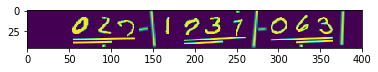

In [25]:
[canvass, locs, labels] = get_line(400)
print(locs)
print(labels)
plt.imshow(canvass)

In [45]:
def get_page(music_sheet_dir, label_dir, max_height, max_width, measure_capacity, padding = 30, inner_line_spacing = 60, show_image = True, simple_version = False, save=False):
    canvass = np.zeros([padding, max_width])
    locs = []
    labels = []
    curr_height = canvass.shape[0]
    while curr_height < max_height:
        new_canvass1 = np.zeros([inner_line_spacing, max_width])
        new_canvass2, new_locs, new_labels = get_line(max_width, measure_capacity, simple_version, padding=padding)
        new_canvass = np.vstack((new_canvass1, new_canvass2))
        if curr_height + new_canvass.shape[0] + padding > max_height:
            break
        for i in range(len(new_locs)):
            new_locs[i][0] += canvass.shape[0] + inner_line_spacing
            new_locs[i][2] += canvass.shape[0] + inner_line_spacing
        canvass = np.vstack((canvass, new_canvass))
        labels += new_labels
        locs += new_locs
        curr_height += new_canvass.shape[0] + inner_line_spacing
    canvass = np.vstack((canvass, np.zeros([max_height - canvass.shape[0], max_width])))
    if save:
        cv2.imwrite(music_sheet_dir, canvass)
    label_array = np.column_stack([np.array(locs), np.array(labels)])
    if show_image:      
        plt.imshow(canvass)
        
    if save:
        with open(label_dir, 'a+') as fp:
            for i in range(len(labels)):
                fp.write(music_sheet_dir + ',' + ','.join(str(e) for e in locs[i]) + ',' + str(labels[i])  + '\n')
    return canvass, labels, locs

[[100, 35, 133, 54], [90, 61, 118, 78], [90, 89, 134, 95], [100, 100, 119, 119], [90, 132, 117, 147], [90, 159, 116, 172], [101, 188, 120, 201], [90, 215, 118, 230], [90, 240, 133, 244], [101, 253, 133, 268], [109, 274, 115, 283], [90, 287, 134, 293], [195, 39, 222, 48], [203, 63, 222, 80], [206, 93, 238, 112], [203, 120, 222, 138], [195, 148, 223, 165], [204, 175, 223, 194], [195, 201, 237, 207], [309, 35, 343, 52], [311, 67, 343, 80], [310, 91, 343, 104], [309, 121, 328, 136], [300, 149, 327, 164], [308, 175, 343, 192], [306, 206, 343, 220], [308, 233, 327, 247], [300, 257, 344, 263]]


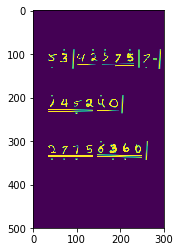

In [46]:
canvass, labels, locs = get_page('sheet.png', 'label.txt', 500, 300, 2)
print(locs)

In [47]:
def generate_music_sheet(num, music_sheet_dir, music_label_dir, height, width, inner_line_spacing, padding, simple_version, measure_capacity = 2):
    curr = 0
    call(["rm", "-rf", music_sheet_dir])
    call(["rm", "-rf", music_label_dir])
    if not os.path.isdir(music_sheet_dir):
        
        os.makedirs(music_sheet_dir)
    if not os.path.isdir(music_label_dir):
        
        os.makedirs(music_label_dir)
    while curr < num:
        sheet_dir = music_sheet_dir + 'img' + str(curr) + '.png'
        label_dir = music_label_dir + 'label' + str(curr) + '.txt'
        get_page(sheet_dir,label_dir,height,width,measure_capacity, show_image=False, simple_version=simple_version)
        curr += 1
        print('Progress: ' + "{0:.0f}%".format(curr / num * 100) )

13500
13500


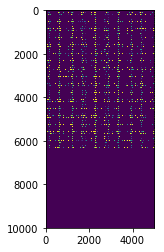

In [290]:
def roi_pooling(canvass, locs, normalized_size = (28,28)):
    global_count = 0
    res = []
    img_root_dir = '../dataset/sheet/training/img'
    for loc in locs:
        img_dir= img_root_dir + str(global_count) + '.png'
        normalized_image = cv2.resize(canvass[loc[0]:loc[2], loc[1]:loc[3]], normalized_size)
        res.append(normalized_image)
        cv2.imwrite(img_dir, normalized_image)
        global_count += 1
    return res
canvass, labels, locs = get_page('sheet.png', 'label.txt', 10000, 5000, 2, simple_version = True)
print(len(locs))
normalized_imgs = roi_pooling(canvass, locs)
print(len(labels))

In [291]:
train_ratio = 0.9
normalized_imgs = np.array(normalized_imgs)
train_img = normalized_imgs[:int(train_ratio*len(normalized_imgs)), :, :]
test_img = normalized_imgs[int(train_ratio*len(normalized_imgs)):, :, :]
train_y = np.array(labels[:int(train_ratio*len(normalized_imgs))])
test_y = np.array(labels[int(train_ratio*len(normalized_imgs)):])
train_img = np.expand_dims(train_img, axis=3)
test_img = np.expand_dims(test_img, axis=3)

In [292]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [316]:
encoder = LabelEncoder()
encoder.fit(labels)
train_y_encoded = encoder.transform(train_y)
test_y_encoded = encoder.transform(test_y)
train_y_encoded_cat = np_utils.to_categorical(train_y_encoded)
test_y_encoded_cat = np_utils.to_categorical(test_y_encoded)

In [294]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [295]:
history = AccuracyHistory()

In [296]:
test_y_encoded.shape

(1350, 23)

In [297]:
from keras.optimizers import Adagrad
import keras
from keras import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [298]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(test_y_encoded.shape[1], activation='softmax'))

In [299]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adagrad(lr=0.0001),
              metrics=['accuracy'])

In [301]:
model.fit(train_img, train_y_encoded,
          batch_size=50,
          epochs=30,
          verbose=1,
          validation_data=(test_img, test_y_encoded))

Train on 12150 samples, validate on 1350 samples
Epoch 1/30
12150/12150 [==============================] - 9s 776us/step - loss: 1.9470 - acc: 0.8403 - val_loss: 2.1067 - val_acc: 0.8193
Epoch 2/30
12150/12150 [==============================] - 10s 829us/step - loss: 1.9240 - acc: 0.8453 - val_loss: 2.0898 - val_acc: 0.8207
Epoch 3/30
12150/12150 [==============================] - 10s 808us/step - loss: 1.9065 - acc: 0.8481 - val_loss: 2.0739 - val_acc: 0.8296
Epoch 4/30
12150/12150 [==============================] - 10s 818us/step - loss: 1.8928 - acc: 0.8497 - val_loss: 2.0679 - val_acc: 0.8356
Epoch 5/30
12150/12150 [==============================] - 10s 817us/step - loss: 1.8818 - acc: 0.8529 - val_loss: 2.0651 - val_acc: 0.8341
Epoch 6/30
12150/12150 [==============================] - 10s 802us/step - loss: 1.8723 - acc: 0.8544 - val_loss: 2.0581 - val_acc: 0.8370
Epoch 7/30
12150/12150 [==============================] - 10s 814us/step - loss: 1.8638 - acc: 0.8563 - val_loss: 2.05

In [317]:
score = model.evaluate(test_img, test_y_encoded_cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.005458299495556
Test accuracy: 0.8474074073191042


In [321]:
pred = model.predict_classes(test_img)

In [323]:
np.sum(test_y_encoded == pred) / len(test_img)

0.8474074074074074

In [192]:
encoded = to_categorical(test_y)

ValueError: invalid literal for int() with base 10: '|'

In [193]:
keys = {}
for y in train_y:
    keys[train_y] = 1

TypeError: unhashable type: 'numpy.ndarray'

In [197]:
encoded_Y

array([67, 22, 16, ..., 15, 18, 67])

In [198]:
test_y

array(['|', '17_16', '15_16', ..., '14_8', '15_8', '|'], dtype='<U5')

In [324]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              1025000   
_________________________________________________________________
dense_21 (Dense)             (None, 23)                23023     
Total para

In [325]:
import coremltools

In [328]:
coreml_model = coremltools.converters.keras.convert(model, input_names='img', output_names='note_class')
coreml_model.save('./MusicNoteClassification.mlmodel')

0 : conv2d_28_input, <keras.engine.topology.InputLayer object at 0x1834e91208>
1 : conv2d_28, <keras.layers.convolutional.Conv2D object at 0x1834e916a0>
2 : conv2d_28__activation__, <keras.layers.core.Activation object at 0x1833638a58>
3 : max_pooling2d_25, <keras.layers.pooling.MaxPooling2D object at 0x1834e91fd0>
4 : conv2d_29, <keras.layers.convolutional.Conv2D object at 0x1834e91550>
5 : conv2d_29__activation__, <keras.layers.core.Activation object at 0x18336385c0>
6 : max_pooling2d_26, <keras.layers.pooling.MaxPooling2D object at 0x18326875c0>
7 : flatten_12, <keras.layers.core.Flatten object at 0x1836958eb8>
8 : dense_20, <keras.layers.core.Dense object at 0x18326870b8>
9 : dense_20__activation__, <keras.layers.core.Activation object at 0x1833638470>
10 : dense_21, <keras.layers.core.Dense object at 0x1832687d30>
11 : dense_21__activation__, <keras.layers.core.Activation object at 0x18336382e8>


In [327]:
pwd

'/Users/YuanShen1/Dropbox/sheet_reader/dataset_generator'

In [329]:
coreml_model.save(filename='MusicNoteClassification.mlmodel')

In [330]:
coreml_model.predict({'img':test_img})

Exception: Model prediction is only supported on macOS version 10.13 or later.

In [339]:
def convert_model(model):
	print('converting...')
	coreml_model = coremltools.converters.keras.convert(model,input_names=['image'],image_input_names='image')
	coreml_model.author = 'YUAN SHEN'
	coreml_model.license = 'MIT'
	coreml_model.short_description = 'Reads a handwritten music note.'
	coreml_model.input_description['image'] = 'A 28x28 pixel Image'
	coreml_model.output_description['output1'] = 'A one-hot Multiarray of the music note class '
	coreml_model.save('MusicNoteClassification.mlmodel')
	print('model converted')

In [340]:
convert_model(model)

converting...
0 : conv2d_28_input, <keras.engine.topology.InputLayer object at 0x1834e91208>
1 : conv2d_28, <keras.layers.convolutional.Conv2D object at 0x1834e916a0>
2 : conv2d_28__activation__, <keras.layers.core.Activation object at 0x1834735828>
3 : max_pooling2d_25, <keras.layers.pooling.MaxPooling2D object at 0x1834e91fd0>
4 : conv2d_29, <keras.layers.convolutional.Conv2D object at 0x1834e91550>
5 : conv2d_29__activation__, <keras.layers.core.Activation object at 0x1834735630>
6 : max_pooling2d_26, <keras.layers.pooling.MaxPooling2D object at 0x18326875c0>
7 : flatten_12, <keras.layers.core.Flatten object at 0x1836958eb8>
8 : dense_20, <keras.layers.core.Dense object at 0x18326870b8>
9 : dense_20__activation__, <keras.layers.core.Activation object at 0x1834735588>
10 : dense_21, <keras.layers.core.Dense object at 0x1832687d30>
11 : dense_21__activation__, <keras.layers.core.Activation object at 0x18347357f0>
model converted
